In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import time
from datetime import datetime
import numpy as np
import matplotlib.patches as mpatches

api_key="8074dc66f62543f89cb5feb0803ce64a"

In [2]:
#series id taken from https://www.bls.gov/help/hlpforma.htm#LA 
#choosing local area unemployment (LA), non-seasonal adjusted (U) (only available option for regional data)

#                      1         2
#Series ID    12345678901234567890
#	Positions    Value            Field Name
#	1-2          LA               Prefix
#	3            U                Seasonal Adjustment Code
#	4-18         CN2810700000000  Area Code
#	19-20        03               Measure Code

#area_type_code	areatype_text
#A	Statewide
#B	Metropolitan areas
#C	Metropolitan divisions
#D	Micropolitan areas
#E	Combined areas
#F	Counties and equivalents
#G	Cities and towns above 25,000 population
#H	Cities and towns below 25,000 population in New England
#I	Parts of cities that cross county boundaries
#J	Multi-entity small labor market areas
#K	Intrastate parts of interstate areas
#L	Balance of state areas
#M	Census regions
#N	Census divisions


#Indicates the unit of measurement:

#06 Labor force,
#05 Employment,
#04 Unemployment, and
#03 Unemployment rate.

#E	CA3640800000000	New York-Newark, NY-NJ-CT-PA Combined Statistical Area	0	T	5179

#E	CA4828800000000	Houston-The Woodlands, TX Combined Statistical Area	0	T	6760
#E	CA4837200000000	Midland-Odessa, TX Combined Statistical Area	0	T	6764
#B	MT4813140000000	Beaumont-Port Arthur, TX Metropolitan Statistical Area	0	T	6686


In [3]:
#Pull New York-Newark, NY-NJ-CT-PA Combined Statistical Area

area_code = "CA3640800000000"

#list of interested measure codes to only pull 03(rate),  06(labor pool), 04(unemployed)
measure_codes=["03","06","04"]


In [4]:
#pull nyc unemployment data

#unemployment rate
url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/LAU{area_code}{measure_codes[0]}?startyear=2000&endyear=2019&registrationkey={api_key}"
nycurd=requests.get(url).json()

#labor pool
url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/LAU{area_code}{measure_codes[1]}?startyear=2000&endyear=2019&registrationkey={api_key}"
nyclpd=requests.get(url).json()

#unemployed
url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/LAU{area_code}{measure_codes[2]}?startyear=2000&endyear=2019&registrationkey={api_key}"
nycud=requests.get(url).json()



In [5]:
#place json into dataframe

df_nycurd_data=pd.DataFrame(nycurd['Results']['series'][0]['data'])
df_nycurd_data.rename(columns={"value":"nyc_u_rate"}, inplace = True)
df_nyclpd_data=pd.DataFrame(nyclpd['Results']['series'][0]['data'])
df_nyclpd_data.rename(columns={"value":"nyc_lbr_pool"}, inplace = True)
df_nycud_data=pd.DataFrame(nycud['Results']['series'][0]['data'])
df_nycud_data.rename(columns={"value":"nyc_unemployed"}, inplace = True)

In [6]:
df_nycurd_data.dtypes
df_nycurd_data["nyc_u_rate"] = df_nycurd_data["nyc_u_rate"].astype("float")
df_nycurd_data.dtypes

footnotes      object
latest         object
period         object
periodName     object
nyc_u_rate    float64
year           object
dtype: object

In [7]:
df_nyclpd_data.head()

footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary.'}]   true    M05        May   
1                                     [{}]    NaN    M04      April   
2                                     [{}]    NaN    M03      March   
3                                     [{}]    NaN    M02   February   
4                                     [{}]    NaN    M01    January   

  nyc_lbr_pool  year  
0     11758114  2019  
1     11728203  2019  
2     11821979  2019  
3     11798862  2019  
4     11771459  2019

In [8]:
df_nycud_data.head()

footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary.'}]   true    M05        May   
1                                     [{}]    NaN    M04      April   
2                                     [{}]    NaN    M03      March   
3                                     [{}]    NaN    M02   February   
4                                     [{}]    NaN    M01    January   

  nyc_unemployed  year  
0         415073  2019  
1         380642  2019  
2         469120  2019  
3         510635  2019  
4         525018  2019

In [9]:
# merge unemployment data into single dataframe

df_nyc = pd.merge(df_nycurd_data[["period","year", "nyc_u_rate"]],df_nyclpd_data[["period","year", "nyc_lbr_pool"]], on=["period","year"], how="outer"  )
df_nyc = pd.merge(df_nyc, df_nycud_data[["period","year", "nyc_unemployed"]], on=["period","year"], how="outer")

df_nyc.head()

period  year  nyc_u_rate nyc_lbr_pool nyc_unemployed
0    M05  2019         3.5     11758114         415073
1    M04  2019         3.2     11728203         380642
2    M03  2019         4.0     11821979         469120
3    M02  2019         4.3     11798862         510635
4    M01  2019         4.5     11771459         525018

In [10]:
#NYC Wage Data

#data_type_code	data_type_text
#1	All Employees, In Thousands
#2	Average Weekly Hours of All Employees
#3	Average Hourly Earnings of All Employees, In Dollars
#6	Production or Nonsupervisory Employees, In Thousands
#7	Average Weekly Hours of Production Employees
#8	Average Hourly Earnings of Production Employees, In Dollars
#11	Average Weekly Earnings of All Employees, In Dollars
#26	All Employees, 3-month average change, In Thousands, seasonally adjusted
#30	Average Weekly Earnings of Production Employees, In Dollars



#93561	New York City, NY
#93562	Orange-Rockland-Westchester, NY
#93563	Bergen-Hudson-Passaic, NJ
#93565	Middlesex-Monmouth-Ocean, NJ

In [11]:
#build series id

#create list to only pull 03(rate) and 06(labor pool)
state_area_codes=["3493563","3493565","3693561","3693562"]

#pull total workers and wages
data_type_codes=["01","03"]

#05000000

In [12]:
#initialize dataframe to hold wage labor pool data
df_nyc_wage_lp_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year','area_code'])


In [13]:
#pull wage labor pool

for i in range(len(state_area_codes)):  
        url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/SMU{state_area_codes[i]}05000000{data_type_codes[0]}?startyear=2000&endyear=2019&registrationkey={api_key}"
        wd=requests.get(url).json()
        df_nyc_wg_lp_data=pd.DataFrame(wd['Results']['series'][0]['data'])
        df_nyc_wg_lp_data["area_code"] = state_area_codes[i]
      
        df_nyc_wage_lp_data=df_nyc_wage_lp_data.append(df_nyc_wg_lp_data,ignore_index=True, sort=False)

In [14]:
df_nyc_wage_lp_data.rename(columns={"value":"nyc_wage_labor_pool"}, inplace = True)
df_nyc_wage_lp_data.head()

footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary'}]   true    M05        May   
1                                    [{}]    NaN    M04      April   
2                                    [{}]    NaN    M03      March   
3                                    [{}]    NaN    M02   February   
4                                    [{}]    NaN    M01    January   

  nyc_wage_labor_pool  year area_code  
0               823.2  2019   3493563  
1               819.9  2019   3493563  
2               815.5  2019   3493563  
3               810.9  2019   3493563  
4               810.6  2019   3493563

In [15]:
#initialize dataframe to hold wage labor pool data
df_nyc_wage_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year'])


In [16]:
#pull wage data

for i in range(len(state_area_codes)):  
        url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/SMU{state_area_codes[i]}05000000{data_type_codes[1]}?startyear=2000&endyear=2019&registrationkey={api_key}"
        wd=requests.get(url).json()
        df_nyc_wg_data=pd.DataFrame(wd['Results']['series'][0]['data'])
        df_nyc_wg_data["area_code"] = state_area_codes[i]
      
        df_nyc_wage_data=df_nyc_wage_data.append(df_nyc_wg_data,ignore_index=True, sort=False)

In [17]:
df_nyc_wage_data.rename(columns={"value":"nyc_wage"}, inplace = True)
df_nyc_wage_data.head()

footnotes latest period periodName nyc_wage  \
0  [{'code': 'P', 'text': 'Preliminary'}]   true    M05        May    28.54   
1                                    [{}]    NaN    M04      April    28.34   
2                                    [{}]    NaN    M03      March    28.03   
3                                    [{}]    NaN    M02   February    28.39   
4                                    [{}]    NaN    M01    January    28.45   

   year area_code  
0  2019   3493563  
1  2019   3493563  
2  2019   3493563  
3  2019   3493563  
4  2019   3493563

In [18]:
df_nyc_wage_ungrp = pd.merge(df_nyc_wage_data[["period","year","area_code",  "nyc_wage"]],df_nyc_wage_lp_data[["period","year", "area_code", "nyc_wage_labor_pool"]], on=["period","year","area_code"], how="outer"  )
df_nyc_wage_ungrp.dropna(inplace=True)
df_nyc_wage_ungrp["nyc_wage"] = df_nyc_wage_ungrp.nyc_wage.astype(float)
df_nyc_wage_ungrp["nyc_wage_labor_pool"] = df_nyc_wage_ungrp.nyc_wage_labor_pool.astype(float)
df_nyc_wage_ungrp["nyc_wages"]=df_nyc_wage_ungrp["nyc_wage"]*df_nyc_wage_ungrp["nyc_wage_labor_pool"]
df_nyc_wage_ungrp.head()

period  year area_code  nyc_wage  nyc_wage_labor_pool  nyc_wages
0    M05  2019   3493563     28.54                823.2  23494.128
1    M04  2019   3493563     28.34                819.9  23235.966
2    M03  2019   3493563     28.03                815.5  22858.465
3    M02  2019   3493563     28.39                810.9  23021.451
4    M01  2019   3493563     28.45                810.6  23061.570

In [19]:
#group data
df_nyc_wage_grp = df_nyc_wage_ungrp.groupby(["year","period"])
df_nyc_wage_grp_with_total = df_nyc_wage_grp["nyc_wages"].sum()/df_nyc_wage_grp["nyc_wage_labor_pool"].sum()
df_nyc_wage = df_nyc_wage_grp_with_total.reset_index()
df_nyc_wage.rename(columns={0:"nyc_wage"}, inplace = True)
df_nyc_wage.head()

year period   nyc_wage
0  2007    M01  27.684418
1  2007    M02  27.593175
2  2007    M03  27.206743
3  2007    M04  27.507567
4  2007    M05  27.003579

In [20]:
# merge unemployment data into single dataframe

df_nyc = pd.merge(df_nycurd_data[["period","year", "nyc_u_rate"]],df_nyclpd_data[["period","year", "nyc_lbr_pool"]], on=["period","year"], how="outer"  )
df_nyc = pd.merge(df_nyc, df_nyc_wage[["period","year", "nyc_wage"]], on=["period","year"], how="outer")

df_nyc.head()

period  year  nyc_u_rate nyc_lbr_pool   nyc_wage
0    M05  2019         3.5     11758114  34.343102
1    M04  2019         3.2     11728203  34.388824
2    M03  2019         4.0     11821979  34.292927
3    M02  2019         4.3     11798862  34.593415
4    M01  2019         4.5     11771459  34.392802

In [21]:
#Pull TX areas

#E	CA4828800000000	Houston-The Woodlands, TX Combined Statistical Area	0	T	6760
#E	CA4837200000000	Midland-Odessa, TX Combined Statistical Area	0	T	6764
#B	MT4813140000000	Beaumont-Port Arthur, TX Metropolitan Statistical Area	0	T	6686


#list of interested measure codes to only pull 06(labor pool), 04(unemployed)
measure_codes=["06","04"]


#create list to pull chosen area codes
area_codes=["CA4828800000000","CA4837200000000","MT4813140000000"]


In [22]:
#initialize dataframe to hold 20 years of state unemployment data
df_TX_lp_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year'])

In [23]:
for i in range(len(area_codes)):  
    url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/LAU{area_codes[i]}{measure_codes[0]}?startyear=2000&endyear=2019&registrationkey={api_key}"
    txlp=requests.get(url).json()
    df_tx_lbr_data=pd.DataFrame(txlp['Results']['series'][0]['data'])

    df_TX_lp_data=df_TX_lp_data.append(df_tx_lbr_data,ignore_index=True, sort=False)


In [24]:
df_TX_lp_data.rename(columns={"value":"TX_labor_pool"}, inplace=True)
df_TX_lp_data["TX_labor_pool"] = df_TX_lp_data.TX_labor_pool.astype(float)
df_TX_lp_data.head()

footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary.'}]   true    M05        May   
1                                     [{}]    NaN    M04      April   
2                                     [{}]    NaN    M03      March   
3                                     [{}]    NaN    M02   February   
4                                     [{}]    NaN    M01    January   

   TX_labor_pool  year  
0      3499781.0  2019  
1      3509430.0  2019  
2      3520353.0  2019  
3      3530713.0  2019  
4      3505605.0  2019

In [25]:
#group data
df_TX_lp_data_grp = df_TX_lp_data.groupby(["year","period"])
df_TX_lp_data_ttl = df_TX_lp_data_grp["TX_labor_pool"].sum()
df_TX_labor = df_TX_lp_data_ttl.reset_index()
df_TX_labor.rename(columns={0:"TX_lbr_pool"}, inplace = True)
df_TX_labor.head()


year period  TX_labor_pool
0  2000    M01      2761525.0
1  2000    M02      2774349.0
2  2000    M03      2780470.0
3  2000    M04      2773947.0
4  2000    M05      2752401.0

In [26]:
#initialize dataframe to hold 20 years of state unemployment data
df_TX_umemp_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year'])

In [27]:
for i in range(len(area_codes)):  
    url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/LAU{area_codes[i]}{measure_codes[1]}?startyear=2000&endyear=2019&registrationkey={api_key}"
    txunemp=requests.get(url).json()
    df_tx_ue_data=pd.DataFrame(txunemp['Results']['series'][0]['data'])

    df_TX_umemp_data=df_TX_umemp_data.append(df_tx_ue_data,ignore_index=True, sort=False)

In [28]:
df_TX_umemp_data.rename(columns={"value":"TX_unemployed"}, inplace=True)
df_TX_umemp_data["TX_unemployed"] = df_TX_umemp_data.TX_unemployed.astype(float)
df_TX_umemp_data.head()


footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary.'}]   true    M05        May   
1                                     [{}]    NaN    M04      April   
2                                     [{}]    NaN    M03      March   
3                                     [{}]    NaN    M02   February   
4                                     [{}]    NaN    M01    January   

   TX_unemployed  year  
0       110824.0  2019  
1       112734.0  2019  
2       131954.0  2019  
3       148111.0  2019  
4       158783.0  2019

In [29]:
#group data
df_TX_ue_data_grp = df_TX_umemp_data.groupby(["year","period"])
df_TX_ue_data_grp_ttl = df_TX_ue_data_grp["TX_unemployed"].sum()
df_TX_ue = df_TX_ue_data_grp_ttl.reset_index()
df_TX_ue.rename(columns={0:"TX_unemployed"}, inplace = True)
df_TX_ue.head()

year period  TX_unemployed
0  2000    M01       137694.0
1  2000    M02       134740.0
2  2000    M03       130150.0
3  2000    M04       115664.0
4  2000    M05       122243.0

In [30]:
df_TX = pd.merge(df_TX_ue, df_TX_labor, on=["period","year"], how="outer")
df_TX["TX_u_rate"] = round((df_TX["TX_unemployed"]/df_TX["TX_labor_pool"])*100, 1)
df_TX.head()

year period  TX_unemployed  TX_labor_pool  TX_u_rate
0  2000    M01       137694.0      2761525.0        5.0
1  2000    M02       134740.0      2774349.0        4.9
2  2000    M03       130150.0      2780470.0        4.7
3  2000    M04       115664.0      2773947.0        4.2
4  2000    M05       122243.0      2752401.0        4.4

In [31]:
#TX Wage Data

#data_type_code	data_type_text
#1	All Employees, In Thousands
#2	Average Weekly Hours of All Employees
#3	Average Hourly Earnings of All Employees, In Dollars
#6	Production or Nonsupervisory Employees, In Thousands
#7	Average Weekly Hours of Production Employees
#8	Average Hourly Earnings of Production Employees, In Dollars
#11	Average Weekly Earnings of All Employees, In Dollars
#26	All Employees, 3-month average change, In Thousands, seasonally adjusted
#30	Average Weekly Earnings of Production Employees, In Dollars



#36220	Odessa, TX
#33260	Midland, TX
#26420	Houston-The Woodlands-Sugar Land, TX
#13140	Beaumont-Port Arthur, TX

In [32]:
#build series id

#create list to only pull 03(rate) and 06(labor pool)
state_area_codes=["4836220","4833260","4826420","4813140"]

#pull total workers and wages
data_type_codes=["01","03"]

#05000000

In [33]:
#initialize dataframe to hold wage labor pool data
df_TX_wage_lp_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year','area_code'])


In [34]:
#pull wage labor pool

for i in range(len(state_area_codes)):  
        url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/SMU{state_area_codes[i]}05000000{data_type_codes[0]}?startyear=2000&endyear=2019&registrationkey={api_key}"
        txwd=requests.get(url).json()
        df_TX_wg_lp_data=pd.DataFrame(txwd['Results']['series'][0]['data'])
        df_TX_wg_lp_data["area_code"] = state_area_codes[i]
      
        df_TX_wage_lp_data=df_TX_wage_lp_data.append(df_TX_wg_lp_data,ignore_index=True, sort=False)

In [35]:
df_TX_wage_lp_data.rename(columns={"value":"TX_wage_labor_pool"}, inplace = True)
df_TX_wage_lp_data.head()

footnotes latest period periodName  \
0  [{'code': 'P', 'text': 'Preliminary'}]   true    M05        May   
1                                    [{}]    NaN    M04      April   
2                                    [{}]    NaN    M03      March   
3                                    [{}]    NaN    M02   February   
4                                    [{}]    NaN    M01    January   

  TX_wage_labor_pool  year area_code  
0               73.7  2019   4836220  
1               73.2  2019   4836220  
2               72.7  2019   4836220  
3               73.1  2019   4836220  
4               73.4  2019   4836220

In [36]:
#initialize dataframe to hold wage labor pool data
df_TX_wage_data = pd.DataFrame(columns=['footnotes', 'latest', 'period', 'periodName', 'value', 'year'])

In [37]:
#pull wage data

for i in range(len(state_area_codes)):  
        url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/SMU{state_area_codes[i]}05000000{data_type_codes[1]}?startyear=2000&endyear=2019&registrationkey={api_key}"
        txwd=requests.get(url).json()
        df_TX_wg_data=pd.DataFrame(txwd['Results']['series'][0]['data'])
        df_TX_wg_data["area_code"] = state_area_codes[i]
      
        df_TX_wage_data=df_TX_wage_data.append(df_TX_wg_data,ignore_index=True, sort=False)

In [38]:
df_TX_wage_data.rename(columns={"value":"TX_wage"}, inplace = True)
df_TX_wage_data.head()

footnotes latest period periodName TX_wage  \
0  [{'code': 'P', 'text': 'Preliminary'}]   true    M05        May   27.31   
1                                    [{}]    NaN    M04      April   27.53   
2                                    [{}]    NaN    M03      March   28.47   
3                                    [{}]    NaN    M02   February   27.44   
4                                    [{}]    NaN    M01    January   27.42   

   year area_code  
0  2019   4836220  
1  2019   4836220  
2  2019   4836220  
3  2019   4836220  
4  2019   4836220

In [39]:
df_TX_wage_ungrp = pd.merge(df_TX_wage_data[["period","year","area_code",  "TX_wage"]],df_TX_wage_lp_data[["period","year", "area_code", "TX_wage_labor_pool"]], on=["period","year","area_code"], how="outer"  )
df_TX_wage_ungrp.dropna(inplace=True)
df_TX_wage_ungrp["TX_wage"] = df_TX_wage_ungrp.TX_wage.astype(float)
df_TX_wage_ungrp["TX_wage_labor_pool"] = df_TX_wage_ungrp.TX_wage_labor_pool.astype(float)
df_TX_wage_ungrp["TX_wages"]=df_TX_wage_ungrp["TX_wage"]*df_TX_wage_ungrp["TX_wage_labor_pool"]
df_TX_wage_ungrp.head()

period  year area_code  TX_wage  TX_wage_labor_pool  TX_wages
0    M05  2019   4836220    27.31                73.7  2012.747
1    M04  2019   4836220    27.53                73.2  2015.196
2    M03  2019   4836220    28.47                72.7  2069.769
3    M02  2019   4836220    27.44                73.1  2005.864
4    M01  2019   4836220    27.42                73.4  2012.628

In [40]:
#group data
df_TX_wage_grp = df_TX_wage_ungrp.groupby(["year","period"])
df_TX_wage_grp_with_total = df_TX_wage_grp["TX_wages"].sum()/df_TX_wage_grp["TX_wage_labor_pool"].sum()
df_TX_wage = df_TX_wage_grp_with_total.reset_index()
df_TX_wage.rename(columns={0:"TX_wage"}, inplace = True)
df_TX_wage.head()

year period    TX_wage
0  2007    M01  22.256440
1  2007    M02  22.286868
2  2007    M03  22.719550
3  2007    M04  23.175656
4  2007    M05  23.059917

In [41]:
# merge data into single dataframe

df_TX = pd.merge(df_TX, df_TX_wage[["period","year", "TX_wage"]], on=["period","year"], how="outer")
df_TX.dropna(inplace=True)

df_TX.head()

year period  TX_unemployed  TX_labor_pool  TX_u_rate    TX_wage
84  2007    M01       142322.0      3085715.0        4.6  22.256440
85  2007    M02       135350.0      3079669.0        4.4  22.286868
86  2007    M03       123433.0      3085955.0        4.0  22.719550
87  2007    M04       120144.0      3080448.0        3.9  23.175656
88  2007    M05       121126.0      3085675.0        3.9  23.059917

In [42]:
df_TX["date"] = df_TX["year"]+"-"+df_TX["period"].str[-2:]+"-01"
df_nyc["date"] = df_nyc["year"]+"-"+df_nyc["period"].str[-2:]+"-01"

In [43]:
nyc_output = "./output/nyc_wage_and_employment.csv"
tx_output = "./output/TX_wage_and_employment.csv"

In [44]:
df_nyc.to_csv(nyc_output, index=False)
df_TX.to_csv(tx_output, index=False)

In [45]:
unemployment_by_year = df_nycurd_data.groupby('year')

# Count how many times each maker appears in our group
nyc_mean_by_year = unemployment_by_year['nyc_u_rate'].mean()

print(nyc_mean_by_year)

year
2000    4.175000
2001    4.600000
2002    6.116667
2003    6.333333
2004    5.533333
2005    4.858333
2006    4.516667
2007    4.391667
2008    5.325000
2009    8.541667
2010    8.933333
2011    8.625000
2012    8.691667
2013    7.866667
2014    6.450000
2015    5.375000
2016    4.841667
2017    4.525000
2018    4.033333
2019    3.900000
Name: nyc_u_rate, dtype: float64


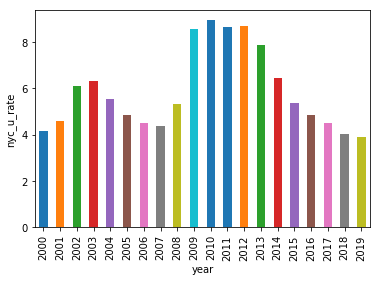

<Figure size 1080x1152 with 0 Axes>

In [46]:
nyc_unemployment_chart = nyc_mean_by_year.plot(kind='bar')

nyc_unemployment_chart.set_xlabel("year")
nyc_unemployment_chart.set_ylabel("nyc_u_rate")
nyc_unemployment_chart = plt.figure(figsize=(15,16))
plt.show()

In [47]:
unemployment_comparison = pd.merge(df_TX, df_nyc, on = 'year')
unemployment_comparison

year period_x  TX_unemployed  TX_labor_pool  TX_u_rate    TX_wage  \
0     2007      M01       142322.0      3085715.0        4.6  22.256440   
1     2007      M01       142322.0      3085715.0        4.6  22.256440   
2     2007      M01       142322.0      3085715.0        4.6  22.256440   
3     2007      M01       142322.0      3085715.0        4.6  22.256440   
4     2007      M01       142322.0      3085715.0        4.6  22.256440   
5     2007      M01       142322.0      3085715.0        4.6  22.256440   
6     2007      M01       142322.0      3085715.0        4.6  22.256440   
7     2007      M01       142322.0      3085715.0        4.6  22.256440   
8     2007      M01       142322.0      3085715.0        4.6  22.256440   
9     2007      M01       142322.0      3085715.0        4.6  22.256440   
10    2007      M01       142322.0      3085715.0        4.6  22.256440   
11    2007      M01       142322.0      3085715.0        4.6  22.256440   
12    2007      M02       135350.0      3079669.0        4.4  22.286868   
13    2007      M02       135350.0      3079669.0        4.4  22.286868   
14    2007      M02       135350.0      3079669.0        4.4  22.286868   
15    2007      M02       135350.0      3079669.0        4.4  22.286868   
16    2007      M02       135350.0      3079669.0        4.4  22.286868   
17    2007      M02       135350.0      3079669.0        4.4  22.286868   
18    2007      M02       135350.0      3079669.0        4.4  22.286868   
19    2007      M02       135350.0      3079669.0        4.4  22.286868   
20    2007      M02       135350.0      3079669.0        4.4  22.286868   
21    2007      M02       135350.0      3079669.0        4.4  22.286868   
22    2007      M02       135350.0      3079669.0        4.4  22.286868   
23    2007      M02       135350.0      3079669.0        4.4  22.286868   
24    2007      M03       123433.0      3085955.0        4.0  22.719550   
25    2007      M03       123433.0      3085955.0        4.0  22.719550   
26    2007      M03       123433.0      3085955.0        4.0  22.719550   
27    2007      M03       123433.0      3085955.0        4.0  22.719550   
28    2007      M03       123433.0      3085955.0        4.0  22.719550   
29    2007      M03       123433.0      3085955.0        4.0  22.719550   
...    ...      ...            ...            ...        ...        ...   
1723  2018      M12       152203.0      3879170.0        3.9  28.321030   
1724  2018      M12       152203.0      3879170.0        3.9  28.321030   
1725  2018      M12       152203.0      3879170.0        3.9  28.321030   
1726  2018      M12       152203.0      3879170.0        3.9  28.321030   
1727  2018      M12       152203.0      3879170.0        3.9  28.321030   
1728  2019      M01       175413.0      3879002.0        4.5  27.884100   
1729  2019      M01       175413.0      3879002.0        4.5  27.884100   
1730  2019      M01       175413.0      3879002.0        4.5  27.884100   
1731  2019      M01       175413.0      3879002.0        4.5  27.884100   
1732  2019      M01       175413.0      3879002.0        4.5  27.884100   
1733  2019      M02       163488.0      3904103.0        4.2  27.821931   
1734  2019      M02       163488.0      3904103.0        4.2  27.821931   
1735  2019      M02       163488.0      3904103.0        4.2  27.821931   
1736  2019      M02       163488.0      3904103.0        4.2  27.821931   
1737  2019      M02       163488.0      3904103.0        4.2  27.821931   
1738  2019      M03       145648.0      3890876.0        3.7  27.683788   
1739  2019      M03       145648.0      3890876.0        3.7  27.683788   
1740  2019      M03       145648.0      3890876.0        3.7  27.683788   
1741  2019      M03       145648.0      3890876.0        3.7  27.683788   
1742  2019      M03       145648.0      3890876.0        3.7  27.683788   
1743  2019      M04       124231.0      3877887.0        3.2  27.641617   
1744  2019      M04       12423

In [48]:
unemployment_by_year = unemployment_comparison.groupby('year')

u_rates_by_year = unemployment_by_year['nyc_u_rate', 'TX_u_rate'].mean()

print(u_rates_by_year)

      nyc_u_rate  TX_u_rate
year                       
2007    4.391667   4.233333
2008    5.325000   4.716667
2009    8.541667   7.641667
2010    8.933333   8.391667
2011    8.625000   7.900000
2012    8.691667   6.716667
2013    7.866667   6.175000
2014    6.450000   5.016667
2015    5.375000   4.683333
2016    4.841667   5.350000
2017    4.525000   5.041667
2018    4.033333   4.283333
2019    3.900000   3.760000


In [49]:
oil_prices = "Oil_Prices/Monthly_Oil_Prices.csv"

oil_prices_by_year = pd.read_csv(oil_prices)

#oil_prices_by_year["date"] = oil_prices_by_year["date"].float["yyyy"]

oil_prices_by_year["oil_price"] = oil_prices_by_year.oil_price.astype(float)

oil_prices_by_year['date'] = oil_prices_by_year['date'].apply(lambda x: datetime.strptime(x,'%Y-%M-%d').strftime('%Y'))

oil_prices_final = oil_prices_by_year.rename(columns={"date":"year"})


oil_prices_final

year  oil_price  pct_chg_oil_price
0    1986      22.93                NaN
1    1986      15.46                NaN
2    1986      12.61                NaN
3    1986      12.84                NaN
4    1986      15.38                NaN
5    1986      13.43                NaN
6    1986      11.59                NaN
7    1986      15.10                NaN
8    1986      14.87                NaN
9    1986      14.90                NaN
10   1986      15.22                NaN
11   1986      16.11                NaN
12   1987      18.65             -18.67
13   1987      17.75              14.81
14   1987      18.30              45.12
15   1987      18.68              45.48
16   1987      19.44              26.40
17   1987      20.07              49.44
18   1987      21.34              84.12
19   1987      20.31              34.50
20   1987      19.53              31.34
21   1987      19.86              33.29
22   1987      18.85              23.85
23   1987      17.28               7.26
24   1988      17.13              -8.15
25   1988      16.80              -5.35
26   1988      16.20             -11.48
27   1988      17.86              -4.39
28   1988      17.42             -10.39
29   1988      16.53             -17.64
..    ...        ...                ...
371  2016      51.97              39.74
372  2017      52.50              65.72
373  2017      53.47              76.35
374  2017      49.33              31.37
375  2017      51.06              25.30
376  2017      48.48               3.79
377  2017      45.18              -7.34
378  2017      46.63               4.43
379  2017      48.04               7.42
380  2017      49.82              10.27
381  2017      51.58               3.62
382  2017      56.64              24.05
383  2017      57.88              11.37
384  2018      63.70              21.33
385  2018      62.23              16.38
386  2018      62.73              27.16
387  2018      66.25              29.75
388  2018      69.98              44.35
389  2018      67.87              50.22
390  2018      70.98              52.22
391  2018      68.06              41.67
392  2018      70.23              40.97
393  2018      70.75              37.17
394  2018      56.96               0.56
395  2018      49.52             -14.44
396  2019      51.38             -19.34
397  2019      54.95             -11.70
398  2019      58.15              -7.30
399  2019      63.86              -3.61
400  2019      60.83             -13.08

[401 rows x 3 columns]

In [50]:
combined_charts = pd.merge(unemployment_comparison, oil_prices_final, how = 'inner', on = 'year')
combined_charts

year period_x  TX_unemployed  TX_labor_pool  TX_u_rate    TX_wage  \
0      2007      M01       142322.0      3085715.0        4.6  22.256440   
1      2007      M01       142322.0      3085715.0        4.6  22.256440   
2      2007      M01       142322.0      3085715.0        4.6  22.256440   
3      2007      M01       142322.0      3085715.0        4.6  22.256440   
4      2007      M01       142322.0      3085715.0        4.6  22.256440   
5      2007      M01       142322.0      3085715.0        4.6  22.256440   
6      2007      M01       142322.0      3085715.0        4.6  22.256440   
7      2007      M01       142322.0      3085715.0        4.6  22.256440   
8      2007      M01       142322.0      3085715.0        4.6  22.256440   
9      2007      M01       142322.0      3085715.0        4.6  22.256440   
10     2007      M01       142322.0      3085715.0        4.6  22.256440   
11     2007      M01       142322.0      3085715.0        4.6  22.256440   
12     2007      M01       142322.0      3085715.0        4.6  22.256440   
13     2007      M01       142322.0      3085715.0        4.6  22.256440   
14     2007      M01       142322.0      3085715.0        4.6  22.256440   
15     2007      M01       142322.0      3085715.0        4.6  22.256440   
16     2007      M01       142322.0      3085715.0        4.6  22.256440   
17     2007      M01       142322.0      3085715.0        4.6  22.256440   
18     2007      M01       142322.0      3085715.0        4.6  22.256440   
19     2007      M01       142322.0      3085715.0        4.6  22.256440   
20     2007      M01       142322.0      3085715.0        4.6  22.256440   
21     2007      M01       142322.0      3085715.0        4.6  22.256440   
22     2007      M01       142322.0      3085715.0        4.6  22.256440   
23     2007      M01       142322.0      3085715.0        4.6  22.256440   
24     2007      M01       142322.0      3085715.0        4.6  22.256440   
25     2007      M01       142322.0      3085715.0        4.6  22.256440   
26     2007      M01       142322.0      3085715.0        4.6  22.256440   
27     2007      M01       142322.0      3085715.0        4.6  22.256440   
28     2007      M01       142322.0      3085715.0        4.6  22.256440   
29     2007      M01       142322.0      3085715.0        4.6  22.256440   
...     ...      ...            ...            ...        ...        ...   
20831  2019      M04       124231.0      3877887.0        3.2  27.641617   
20832  2019      M04       124231.0      3877887.0        3.2  27.641617   
20833  2019      M04       124231.0      3877887.0        3.2  27.641617   
20834  2019      M04       124231.0      3877887.0        3.2  27.641617   
20835  2019      M04       124231.0      3877887.0        3.2  27.641617   
20836  2019      M05       122379.0      3868089.0        3.2  27.748435   
20837  2019      M05       122379.0      3868089.0        3.2  27.748435   
20838  2019      M05       122379.0      3868089.0        3.2  27.748435   
20839  2019      M05       122379.0      3868089.0        3.2  27.748435   
20840  2019      M05       122379.0      3868089.0        3.2  27.748435   
20841  2019      M05       122379.0      3868089.0        3.2  27.748435   
20842  2019      M05       122379.0      3868089.0        3.2  27.748435   
20843  2019      M05       122379.0      3868089.0        3.2  27.748435   
20844  2019      M05       122379.0      3868089.0        3.2  27.748435   
20845  2019      M05       122379.0      3868089.0        3.2  27.748435   
20846  2019      M05       122379.0      3868089.0        3.2  27.748435   
20847  2019      M05       122379.0      3868089.0        3.2  27.748435   
20848  2019      M05       122379.0      3868089.0        3.2  27.748435   
20849  2019      M05       122379.0      3868089.0        3.2  27.748435   
20850  2019      M05       122379.0      3868089.0        3.2  27.748435   
20851  2019      M05       122379.0      3868089.0     

In [152]:
grouped_combined_charts = combined_charts.groupby('year')
averaged_combined_charts = grouped_combined_charts['nyc_u_rate', 'TX_u_rate', 'oil_price'].mean()
final_chart = averaged_combined_charts.rename(columns={"nyc_u_rate":"NYC Unemployment Rate",
                                        "TX_u_rate":"Texas Unemployment Rate"})
final_chart

NYC Unemployment Rate  Texas Unemployment Rate  oil_price
year                                                           
2007               4.391667                 4.233333  72.318333
2008               5.325000                 4.716667  99.571667
2009               8.541667                 7.641667  61.654167
2010               8.933333                 8.391667  79.395000
2011               8.625000                 7.900000  94.874167
2012               8.691667                 6.716667  94.110833
2013               7.866667                 6.175000  97.905833
2014               6.450000                 5.016667  93.258333
2015               5.375000                 4.683333  48.688333
2016               4.841667                 5.350000  43.144167
2017               4.525000                 5.041667  50.884167
2018               4.033333                 4.283333  64.938333
2019               3.900000                 3.760000  57.834000

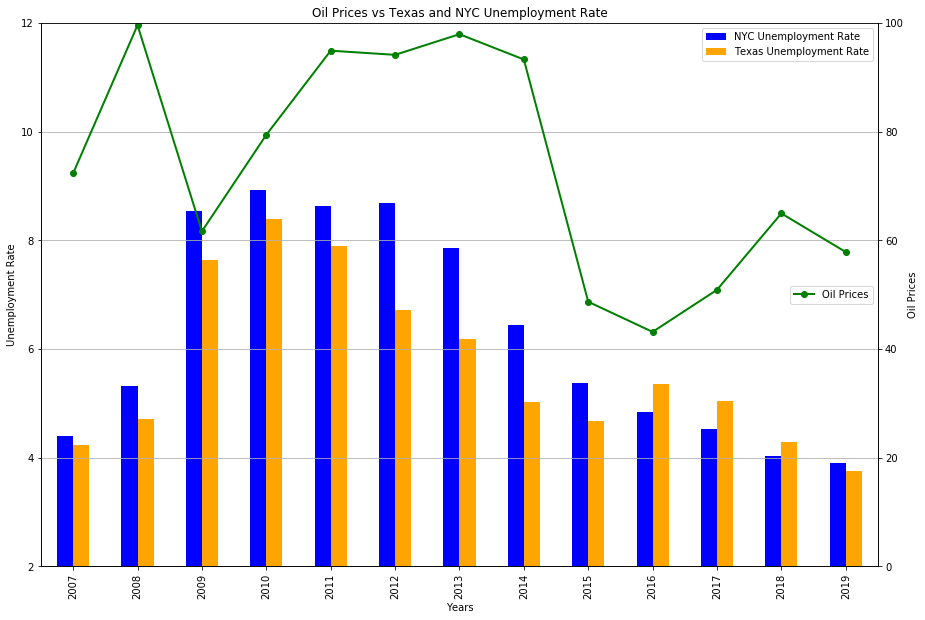

In [155]:
ax = final_chart[["NYC Unemployment Rate",'Texas Unemployment Rate']].plot(kind='bar', figsize = (15,10), color = ("blue","orange"))
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         final_chart[['oil_price']].values,
         linestyle='-',
         marker='o', linewidth=2.0, color = 'green', label = "Oil Prices")
ax.set_ylim((2,12))
ax2.set_ylim((0, 100))

ax.set_xlabel("Years")
ax.set_ylabel("Unemployment Rate")
ax2.set_ylabel("Oil Prices")

plt.legend(loc="right")

ax = plt.gca()

ax.grid()

plt.title("Oil Prices vs Texas and NYC Unemployment Rate")

plt.savefig ('Output/Oil_Prices_v_Unemployment.png')


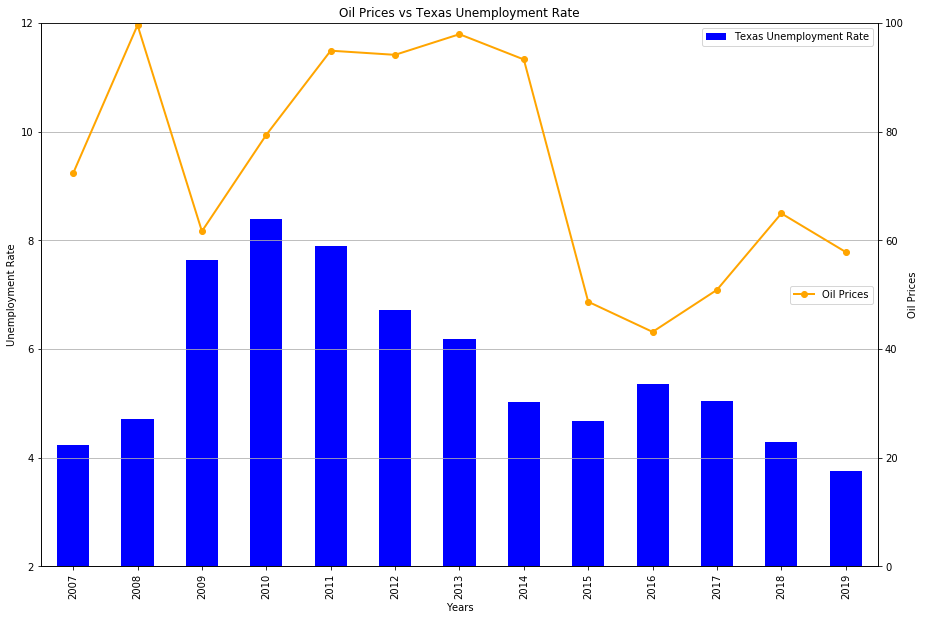

In [157]:
ax = final_chart[['Texas Unemployment Rate']].plot(kind='bar', figsize = (15,10), color = ("blue","orange"))
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         final_chart[['oil_price']].values,
         linestyle='-',
         marker='o', linewidth=2.0, color = 'orange', label = "Oil Prices")
ax.set_ylim((2,12))
ax2.set_ylim((0, 100))

ax.set_xlabel("Years")
ax.set_ylabel("Unemployment Rate")
ax2.set_ylabel("Oil Prices")

plt.legend(loc="right")

ax = plt.gca()

ax.grid()

plt.title("Oil Prices vs Texas Unemployment Rate")

plt.savefig ('Output/Oil_Prices_v_TX_Unemployment.png')


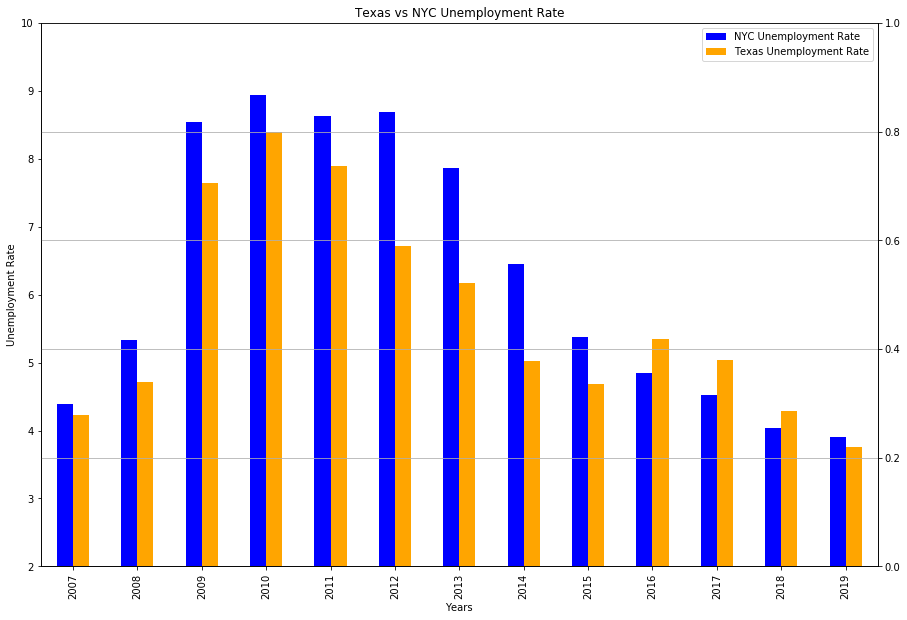

In [161]:
ax = final_chart[["NYC Unemployment Rate",'Texas Unemployment Rate']].plot(kind='bar', figsize = (15,10), color = ("blue","orange"))
ax2 = ax.twinx()

ax.set_ylim((2,10))

ax.set_xlabel("Years")
ax.set_ylabel("Unemployment Rate")

ax = plt.gca()

ax.grid()

plt.title("Texas vs NYC Unemployment Rate")

plt.savefig ('Output/TX_v_NY_Unemployment.png')


In [158]:
wages_by_year = unemployment_by_year['nyc_wage', 'TX_wage'].mean()

wages_by_year

nyc_wage    TX_wage
year                      
2007  27.390231  22.993641
2008  28.956136  23.697867
2009  28.993113  24.091709
2010  29.243922  24.271174
2011  29.188165  24.568850
2012  29.534722  24.643242
2013  29.896563  25.302747
2014  30.289020  26.363259
2015  31.381210  27.087450
2016  31.879745  26.990616
2017  32.527406  27.237982
2018  33.477872  27.487132
2019  34.402214  27.755974

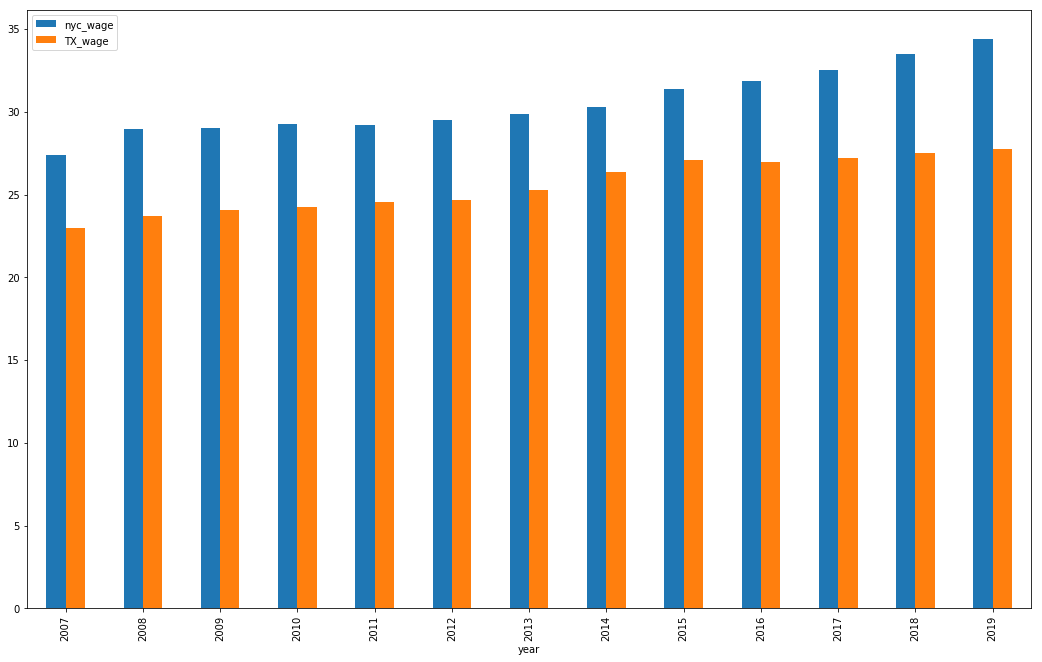

In [159]:
wages_chart = wages_by_year.plot(kind='bar',figsize = (18,11))
plt.show()